In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flg-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import flg_model
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [6]:
all_data = fls.load_all_train_data()
np.random.default_rng(seed=0).shuffle(all_data)

# Pick N tomograms with 1 motor and N tomograms with 0 motors as validation set
N=100
n_motors = np.array([len(d.labels) for d in all_data])
inds_zero = np.argwhere(n_motors==0)[:N,0]
inds_one = np.argwhere(n_motors==1)[:N,0]
inds_test = np.concatenate((inds_zero,inds_one))
inds_train = np.setdiff1d(np.arange(len(n_motors)), inds_test)
inds_test.shape, inds_train.shape

train_data = []
for i in inds_train:
    train_data.append(all_data[i])
test_data = []
for i in inds_test:
    test_data.append(all_data[i])
np.random.default_rng(seed=0).shuffle(test_data)
len(train_data), len(test_data)

(444, 200)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

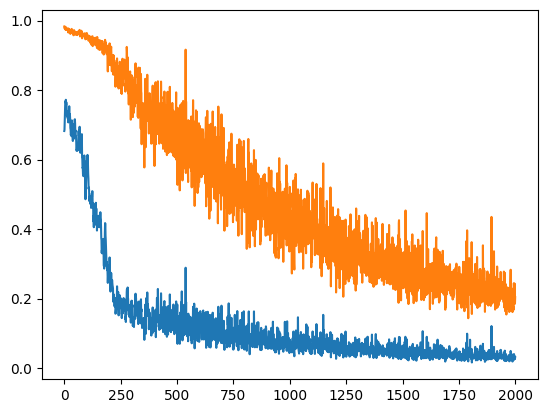

In [3]:
%%time
fls.profiling=False
model = flg_model.ThreeStepModel()
model.step1Heatmap.n_epochs = 2000
model.train(train_data)
plt.figure()
plt.plot(model.step1Heatmap.train_loss_list1)
plt.plot(model.step1Heatmap.train_loss_list2)
fls.dill_save(fls.temp_dir + 'model_temp.pickle', model)

In [3]:
%%time
fls.profiling = False
model = fls.dill_load(fls.temp_dir + 'model_temp.pickle')
inferred_test_data = model.infer(test_data)
#inferred_train_data = model.infer(train_data);
# for inf,test in zip(inferred_test_data, this_test_data):
#     print('')
#     print('')
#     print(test.name)
#     print(test.labels)
#     print(inf.labels)

CPU times: user 22min 2s, sys: 15min 3s, total: 37min 5s
Wall time: 38min 36s


In [4]:
fls.dill_save(fls.temp_dir + 'res.pickle', (inferred_test_data, test_data))

In [13]:
importlib.reload(fls)
inferred_test_data, test_data = fls.dill_load(fls.temp_dir + 'res.pickle')

In [8]:
import sklearn
import pandas as pd

def distance_metric(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    thresh_ratio: float,
    min_radius: float,
):
    coordinate_cols = ['Motor axis 0', 'Motor axis 1', 'Motor axis 2']
    label_tensor = solution[coordinate_cols].values.reshape(len(solution), -1, len(coordinate_cols))
    predicted_tensor = submission[coordinate_cols].values.reshape(len(submission), -1, len(coordinate_cols))
    # Find the minimum euclidean distances between the true and predicted points
    solution['distance'] = np.linalg.norm(label_tensor - predicted_tensor, axis=2).min(axis=1)
    # Convert thresholds from angstroms to voxels
    solution['thresholds'] = solution['Voxel spacing'].apply(lambda x: (min_radius * thresh_ratio) / x)
    solution['predictions'] = submission['Has motor'].values
    solution.loc[(solution['distance'] > solution['thresholds']) & (solution['Has motor'] == 1) & (submission['Has motor'] == 1), 'predictions'] = 0
    return solution['predictions'].values
    
def score(solution: pd.DataFrame, submission: pd.DataFrame, min_radius: float, beta: float) -> float:
    """
    Parameters:
    solution (pd.DataFrame): DataFrame containing ground truth motor positions.
    submission (pd.DataFrame): DataFrame containing predicted motor positions.

    Returns:
    float: FBeta score.

    Example
    --------
    >>> solution = pd.DataFrame({
    ...     'tomo_id': [0, 1, 2, 3],
    ...     'Motor axis 0': [-1, 250, 100, 200],
    ...     'Motor axis 1': [-1, 250, 100, 200],
    ...     'Motor axis 2': [-1, 250, 100, 200],
    ...     'Voxel spacing': [10, 10, 10, 10],
    ...     'Has motor': [0, 1, 1, 1]
    ... })
    >>> submission = pd.DataFrame({
    ...     'tomo_id': [0, 1, 2, 3],
    ...     'Motor axis 0': [100, 251, 600, -1],
    ...     'Motor axis 1': [100, 251, 600, -1],
    ...     'Motor axis 2': [100, 251, 600, -1]
    ... })
    >>> score(solution, submission, 1000, 2)
    0.3571428571428571
    """

    solution = solution.sort_values('tomo_id').reset_index(drop=True)
    submission = submission.sort_values('tomo_id').reset_index(drop=True)

    filename_equiv_array = solution['tomo_id'].eq(submission['tomo_id'], fill_value=0).values

    if np.sum(filename_equiv_array) != len(solution['tomo_id']):
        raise ValueError('Submitted tomo_id values do not match the sample_submission file')

    submission['Has motor'] = 1
    # If any columns are missing an axis, it's marked with no motor
    select = (submission[['Motor axis 0', 'Motor axis 1', 'Motor axis 2']] == -1).any(axis='columns')
    submission.loc[select, 'Has motor'] = 0

    cols = ['Has motor', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']
    assert all(col in submission.columns for col in cols)

    # Calculate a label of 0 or 1 using the 'has motor', and 'motor axis' values
    predictions = distance_metric(
        solution,
        submission,
        thresh_ratio=1.0,
        min_radius=min_radius,
    )

    return sklearn.metrics.fbeta_score(solution['Has motor'].values, predictions, beta=beta)

In [7]:
row_df_sub = fls.create_submission_dataframe(inferred_test_data, reference_data = test_data)
row_df_ref = fls.create_submission_dataframe(test_data, reference_data = test_data, include_voxel_spacing=True)
print(score(row_df_ref, row_df_sub, 1000, 2))

0.6762295081967213


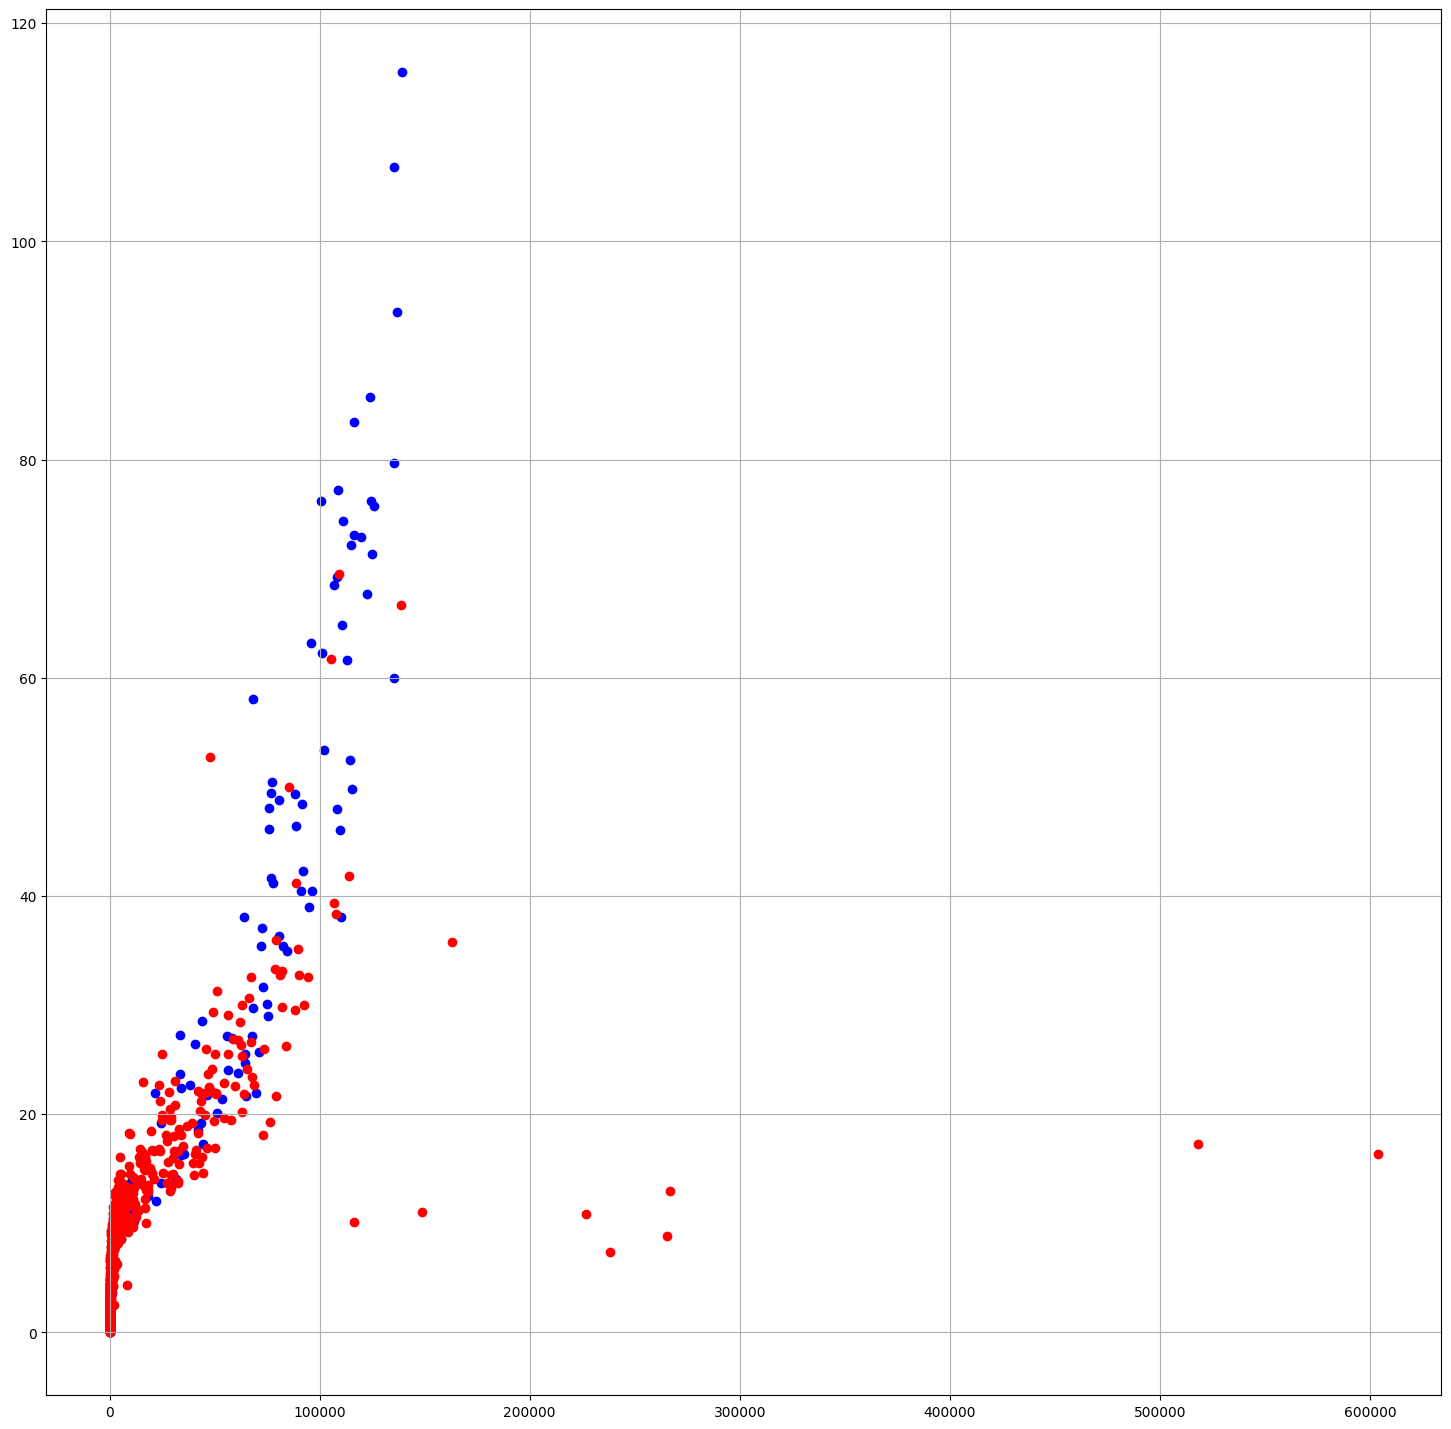

In [41]:
importlib.reload(fls)
inferred_test_data, test_data = fls.dill_load(fls.temp_dir + 'res.pickle')
fls.mark_tf_pn(inferred_test_data, test_data)
cs_tp = []
cs_fp = []
log_tp = []
log_fp = []
for t in inferred_test_data:
    for d in range(len(t.labels_unfiltered)):
        #print( t.labels_unfiltered['tf_pn']
        if t.labels_unfiltered['tf_pn'][d]==0:
            cs_tp.append(t.labels_unfiltered['size'][d])
            log_tp.append(t.labels_unfiltered['max_logit'][d])
        if t.labels_unfiltered['tf_pn'][d]==1:
            cs_fp.append(t.labels_unfiltered['size'][d])
            log_fp.append(t.labels_unfiltered['max_logit'][d])
plt.figure(figsize=(18,18))
plt.scatter(cs_tp, log_tp, color='blue')
plt.scatter(cs_fp, log_fp, color='red')
plt.grid(True)

In [ ]:
epochs = [400,800,1200,1600]
scores = []
for epoch in epochs:
    model = fls.dill_load(fls.temp_dir + 'model_temp.pickle')
    model.step1Heatmap.model = fls.dill_load(fls.temp_dir + 'intermediate_model_' +str(epoch)+ '.pickle')
    this_test_data = copy.deepcopy(test_data)
    inferred_test_data = model.infer(this_test_data)
    row_df_sub = fls.create_submission_dataframe(inferred_test_data, reference_data = this_test_data)
    row_df_ref = fls.create_submission_dataframe(this_test_data, reference_data = this_test_data, include_voxel_spacing=True)
    print(score(row_df_ref, row_df_sub, 1000, 2))
    scores.append(score(row_df_ref, row_df_sub, 1000, 2))
fls.dill_save(fls.temp_dir + 'scores.pickle', (epochs,scores))

KeyboardInterrupt: 

In [14]:
inferred_test_data

[Data(is_train=True, name='tomo_ff505c', labels=     z    y    x    size  max_logit
 1  112  812  677  114873    72.1875, labels_unfiltered=     z    y    x    size  max_logit
 0   31  942  803     256   3.814453
 1  112  812  677  114873  72.187500
 2  142  462  672    5412  12.343750
 3  135  685  464      34   0.492676, loaded_state='unloaded', data=None, voxel_spacing=6.5, mean_per_slice=array([], dtype=float64), std_per_slice=array([], dtype=float64)),
 Data(is_train=True, name='tomo_6c4df3', labels=Empty DataFrame
 Columns: [z, y, x, size, max_logit]
 Index: [], labels_unfiltered=Empty DataFrame
 Columns: [z, y, x, size, max_logit]
 Index: [], loaded_state='unloaded', data=None, voxel_spacing=6.5, mean_per_slice=array([], dtype=float64), std_per_slice=array([], dtype=float64)),
 Data(is_train=True, name='tomo_62dbea', labels=     z    y    x   size  max_logit
 0  129  592  531  63292  30.046875, labels_unfiltered=     z    y    x   size  max_logit
 0  129  592  531  63292  30.046